In [10]:
# TODO
# Clip CS2 to SARIn mode mask? (at least for each epochs before it moved inland?
# SARIn mode masks - should you set 4326 then convert to 3031?

# Set up computing environment

In [11]:
# Install dependencies not pre-installed
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Import libraries
import datetime
import earthaccess
import geopandas as gpd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
from pyproj import CRS, Transformer
from scipy.ndimage import zoom
import xarray as xr
from shapely.geometry import MultiPolygon, Point, Polygon

# Magic functions
%matplotlib widget

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_evolving_Ant_subglacial_hydro/output/0_preprocess_data.ipynb'

# Functions

In [13]:
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

In [14]:
def transform_geometry(geometry):
    """
    Transform the geometry of a GeoDataFrame row from lon/lat to polar stereographic.
    Handles Points, Polygons, and MultiPolygons.
    """
    if geometry.geom_type == 'Polygon':
        exterior = [(x, y) for x, y in zip(*geometry.exterior.coords.xy)]
        transformed_exterior = [ll2ps(lon, lat) for lon, lat in exterior]
        new_polygon = Polygon(transformed_exterior)
        return new_polygon
    elif geometry.geom_type == 'Point':
        x, y = ll2ps(*geometry.coords[0])
        return Point(x, y)
    elif geometry.geom_type == 'MultiPolygon':
        new_polygons = []
        for polygon in geometry.geoms:
            exterior = [(x, y) for x, y in zip(*polygon.exterior.coords.xy)]
            transformed_exterior = [ll2ps(lon, lat) for lon, lat in exterior]
            new_polygons.append(Polygon(transformed_exterior))
        return MultiPolygon(new_polygons)
    else:
        # Add support for other geometry types as needed
        raise ValueError(f"Unsupported geometry type: {geometry.geom_type}")

# Import datasets

## Import previously identified subglacial lake locations

In [17]:
# Import subglacial lake outlines
static_lakes_gdf = gpd.read_file('/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/static_lakes_gdf.geojson')

## Import the ATL14 DEM

In [18]:
# Log into NASA Earthdata to search for datasets
earthaccess.login()

In [19]:
# Find ICESat-2 ATL14 data granules
results = earthaccess.search_data(
    short_name='ATL14',
    version='003',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 4


In [20]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)

Opening 4 granules, approx size: 10.78 GB
using provider: NSIDC_CPRD


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
files

[<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/003/ATL14_A3_0318_100m_003_01.nc>,
 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/003/ATL14_A2_0318_100m_003_01.nc>,
 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/003/ATL14_A4_0318_100m_003_01.nc>,
 <File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL14/003/ATL14_A1_0318_100m_003_01.nc>]

In [22]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL14_A1 = xr.open_dataset(files[3])
ATL14_A2 = xr.open_dataset(files[1])
ATL14_A3 = xr.open_dataset(files[0])
ATL14_A4 = xr.open_dataset(files[2])

In [23]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'h']

# List of xarray datasets
datasets = [ATL14_A1, ATL14_A2, ATL14_A3, ATL14_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL14_A1, ATL14_A2, ATL14_A3, ATL14_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [24]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL14_A12 = xr.concat([ATL14_A2.isel(x=slice(0,-1)), ATL14_A1], dim="x")

In [25]:
# Delete quadrants no longer needed
del ATL14_A1, ATL14_A2

In [26]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL14_A34 = xr.concat([ATL14_A3.isel(x=slice(0,-1)), ATL14_A4], dim='x')

In [27]:
# Delete quadrants no longer needed
del ATL14_A3, ATL14_A4

In [ ]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL14 = xr.concat([ATL14_A34.isel(y=slice(0,-1)), ATL14_A12], dim='y')

In [ ]:
# Delete intermediary files no longer needed
del ATL14_A12, ATL14_A34

In [ ]:
ATL14

## Import the Smith and others, 2017, TC method CryoSat-2 SARIn gridded DEM and dh data

In [ ]:
# Import Smith and others, 2017, TC method CryoSat-2 (CS2) SARIn DEM data 
# https://doi.org/10.5194/tc-11-451-2017
# (closed source aquired from Ben Smith)
CS2_Smith2017_DEM = xr.open_dataset(
    DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_z0_2016.0.nc')

# View dataset metadata
CS2_Smith2017_DEM

In [ ]:
# Contstruct DEM using z0, SMB, and FAC
# The DEM (z0) is corrected for SMB_a and FAC: 
# To get the actual surface elevation, add SMB_a+FAC.  
# To get the FAC-free elevation, just add SMB_a
CS2_Smith2017_DEM = CS2_Smith2017_DEM.assign(DEM = CS2_Smith2017_DEM['z0'] + CS2_Smith2017_DEM['SMB_a'] + CS2_Smith2017_DEM['FAC'])
CS2_Smith2017_DEM

In [ ]:
# CS2_Smith2017_DEM['DEM'][:,:].plot()

In [ ]:
# Import Smith and others, 2017, TC method CryoSat-2 SARIn delta height data (closed source aquired from Ben Smith)
CS2_Smith2017_dh = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2021.5.nc')
CS2_Smith2017_dh

In [ ]:
# Interpolate CS2_DEM_agg onto the coordinate grid of CS2_dh['delta_h']
CS2_Smith2017_DEM_agg = CS2_Smith2017_DEM['DEM'].interp(x=CS2_Smith2017_dh['delta_h'].x, y=CS2_Smith2017_dh['delta_h'].y)

In [ ]:
# Print shape of the datasets to be combined
print(CS2_Smith2017_DEM.DEM.shape)
print(CS2_Smith2017_DEM_agg.shape)
print(CS2_Smith2017_dh.delta_h.shape)

In [ ]:
# Assign actual heights by combing dh's with the 2016 DEM
CS2_Smith2017_dh['h'] = CS2_Smith2017_dh['delta_h'] + CS2_Smith2017_DEM_agg

In [ ]:
# Reassign (rename) geodataframe to reflect more than dh
CS2_Smith2017 = CS2_Smith2017_dh

# Delete original reference (name)
del CS2_Smith2017_dh

In [ ]:
# Delete delta_h data variable so; we can replace with delta_h relative to ATL14 DEM
CS2_Smith2017 = CS2_Smith2017.drop_vars('delta_h')

In [ ]:
# Rename data variable to match ICESat-2 ATL15 data product
CS2_Smith2017 = CS2_Smith2017.rename({'count': 'data_count'})
CS2_Smith2017

In [ ]:
# Assign delta heights differencing absolute heights with the ATL14 DEM
CS2_Smith2017['delta_h'] = CS2_Smith2017['h'] - ATL14['h']
# CS2_dh = CS2_dh.assign(delta_h = CS2_dh['h'] - ATL14['h'])

# Add a 'description' attribute to the 'h' data variable
CS2_Smith2017['delta_h'].attrs['description'] = 'Height change relative to the ATL14 datum (Jan 1, 2020) surface'

CS2_Smith2017

In [ ]:
# Create lists to store data
cyc_dates = []

# Change time to match ICESat-2 time format
for idx in range(len(CS2_Smith2017['time'])):
    # Smith and others, 2017 method CryoSat-2 SARIn data
    cyc_date = datetime.datetime(int(CS2_Smith2017['time'].values[idx]), 1, 1) + datetime.timedelta(days = (CS2_Smith2017['time'].values[idx] % 1) * 365.25)
    cyc_date_np_dt = np.datetime64(cyc_date)  # Convert to numpy.datetime64 format
    cyc_dates += [cyc_date_np_dt]
CS2_Smith2017_newtime = CS2_Smith2017.assign_coords(time=cyc_dates)

# Add a 'description' attribute to the 'time' data variable
CS2_Smith2017_newtime.coords['time'].attrs['description'] = 'Time for each node'

# Delete unneeded list
del cyc_dates
del CS2_Smith2017

CS2_Smith2017_newtime

In [ ]:
# Remove time slices that occur during the ICESat-2 era that will not be used to conserve memory when loaded in the future
# Subset the dataset for a specific time range
start_date = np.datetime64('2010-07-02T15:00:00.000000000')
# end_date = np.datetime64('2018-07-02T15:00:00.000000000')  # No temporal overlap
end_date = np.datetime64('2018-10-01T22:30:00.000000000')  # Includes one quarter of overlapping data allow for cyc start/end accounting 

CS2_Smith2017_subset = CS2_Smith2017_newtime.sel(time=slice(start_date, end_date))

CS2_Smith2017_subset

# CryoSat-2 SARIn mode mask

In [ ]:
# CryoSat-2 Geographical Mode Mask
# https://earth.esa.int/eogateway/instruments/siral/geographical-mode-mask
# Downloaded kml files and coverted to geojson files in terminal using command:
# ogr2ogr -f GeoJSON Cryosat2_mode_mask_v3.1.geojson Cryosat2_mode_mask_v3.1.kml

# Initialize an empty dictionary to store the GeoDataFrames
gdfs = {}

# Loop over the specified range
for idx in range(1, 10):  # Only doing up to version 9 because that temporally covers the pre-ICESat-2 era
    # Construct the file path
    file_path = f'input/CryoSat2_mode_masks/Cryosat2_mode_mask_v3.{idx}.geojson'
    # Read the GeoJSON file and store it in the dictionary with a key corresponding to the current index
    gdfs[f'gdf_3.{idx}'] = gpd.read_file(file_path)
    
# View head of first gdf to ensure readin worked properly
gdfs['gdf_3.1'].head()

In [ ]:
# Names to filter by
descrip_1 = 'LRM over Antarctica ice sheet'  # Interior Antarctica LRM limit
descrip_2 = 'SARIn in Antarctica'  # Coastal Antarctic SARIn mode limit

# Ensure geodataframes are not already transformed to epsg3031
if gdfs['gdf_3.1'].crs != 'EPSG:3031':
    for key, gdf in gdfs.items():
        # Create a boolean mask for filtering
        mask = gdf['description'].isin([descrip_1, descrip_2])

        # Apply the mask using .loc to filter rows
        gdf_filtered = gdf.loc[mask].copy()  # Using .copy() to explicitly make a copy

        # Apply the transformation to the geometry of the filtered GeoDataFrame
        gdf_filtered['geometry'] = gdf_filtered['geometry'].apply(transform_geometry)

        # Set the new CRS for the filtered GeoDataFrame to EPSG:3031
        gdf_filtered.set_crs("EPSG:3031", inplace=True, allow_override=True)

        # Update the dictionary with the filtered and transformed GeoDataFrame
        gdfs[key] = gdf_filtered
    
# View head of first gdf to ensure transformation worked properly
gdfs['gdf_3.1'].head()

In [ ]:
# Plot all version of CS2 mode mask to see how it's changed

# Prepare a list of colors, enough to cover the number of GeoDataFrames
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']

# Create a new figure and axis for plotting
fig, ax = plt.subplots()

# Iterate over each GeoDataFrame in the dictionary
for (key, gdf), color in zip(gdfs.items(), colors):
    # Plot each GeoDataFrame with a unique color
    gdf.plot(ax=ax, edgecolor=color, facecolor='none', label=key)

# Overlay previously identified lake locations 
static_lakes_gdf.boundary.plot(ax=ax, color='blue', label=key)
    
# Show the plot
plt.show()

In [ ]:
# LRM mode limit has migrated during the CS2 era not including IS2 era (2010-2018); we can use area of the LRM mode to find when the mode mask shifted
# Iterate over each GeoDataFrame in the dictionary
for key, gdf in gdfs.items():
    # Calculate the area of each geometry and assign it to a new column 'area'
    # Note: This assumes the geometries are in a suitable CRS for area calculation
    gdf['area'] = gdf.geometry.area
    
    # Update the dictionary with the modified GeoDataFrame
    gdfs[key] = gdf

In [ ]:
# Check if running in an interactive environment like Jupyter Notebook
# and try to import the display function from IPython.display
try:
    from IPython.display import display
    interactive_environment = True
except ImportError:
    interactive_environment = False
    
# The description to filter by
filter_description = 'LRM over Antarctica ice sheet'

# Iterate over each GeoDataFrame in the dictionary
for key, gdf in gdfs.items():
    print(f"GeoDataFrame Key: {key} - Rows with Description: '{filter_description}'")
    
    # Filter the GeoDataFrame based on the 'description' column
    filtered_gdf = gdf[gdf['description'] == filter_description]
    
    # Check if the filtered GeoDataFrame is not empty
    if not filtered_gdf.empty:
        # If in an interactive environment, use display for a nicer format
        if interactive_environment:
            display(filtered_gdf)
        else:
            print(filtered_gdf)
    else:
        print("No rows match the specified description.")
    print("\n")  # Add a newline for better separation

In [ ]:
# Version 3.6 (October 2014) is when the LRM mask shrank to smaller area

In [ ]:
# Plot CS2 counts with the SARIn mode mask
import matplotlib.lines as mlines
# Set x, y min, max bounds for plotting
x_min=CS2_Smith2017_subset['x'].min()
x_max=CS2_Smith2017_subset['x'].max()
y_min=CS2_Smith2017_subset['y'].min()
y_max=CS2_Smith2017_subset['y'].max()

for time_value in CS2_Smith2017_subset['time'].values:
    fig, ax = plt.subplots(figsize=(10,10))

    # Check if the time value is less than 2014.75
    if time_value < np.datetime64('2013-10-01T22:20:00.000000000'):
        # Access the part of the dataset corresponding to this time
        # This might involve selecting data based on the 'time' coordinate
        selected_data = CS2_Smith2017_subset.sel(time=time_value)
        m = ax.imshow(selected_data['data_count'][:,:], 
        extent=[x_min, x_max, y_min, y_max],
        cmap='viridis', 
        vmax=1,  # Set colormapping max to 1 to highlight data-poor regions
        origin='lower')
    
        # Plotting CS2 mode mask polygons from version 3.1 for time periods during version 3.1 to 3.5 since they don't change
        gdfs['gdf_3.1'].plot(ax=ax, edgecolor='red', facecolor='none', zorder=2, label='SARIn mode mask 3.1')
        # Plotting inland buffer to show how far data_counts extends inland of CS2 SARIn mode mask boundary
        # to include edge case lakes Byrd_s1, Foundation_2, and Mac3 when including CS2 data into evolving outline search
        gdfs['gdf_3.1'].buffer(-15e3).plot(ax=ax, edgecolor='purple', facecolor='none', zorder=2, label='SARIn mode mask 3.1 - 15 km inland buffer')
        gdfs['gdf_3.6'].plot(ax=ax, edgecolor='blue', facecolor='none', zorder=2, label='SARIn mode mask 3.6')
        
        # Plot subglacial lake outlines
        static_lakes_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', zorder=3, label='active subglacial lake')

    elif time_value >= np.datetime64('2013-10-01T22:20:00.000000000'):
        # Access the part of the dataset corresponding to this time
        # This might involve selecting data based on the 'time' coordinate
        selected_data = CS2_Smith2017_subset.sel(time=time_value)
        m = ax.imshow(selected_data['data_count'][:,:], 
        extent=[x_min, x_max, y_min, y_max],
        cmap='viridis', 
        vmax=1,  # Set colormapping max to 1 to highlight data-poor regions
        origin='lower')
    
        # Plotting CS2 mode mask polygons from version 3.6 for time periods during version 3.6 to 3.9 since they don't change
        gdfs['gdf_3.1'].plot(ax=ax, edgecolor='red', facecolor='none', zorder=2, label='SARIn mode mask 3.1')
        gdfs['gdf_3.6'].plot(ax=ax, edgecolor='blue', facecolor='none', zorder=2, label='SARIn mode mask 3.6')
        gdfs['gdf_3.6'].buffer(-15e3).plot(ax=ax, edgecolor='purple', facecolor='none', zorder=2, label='SARIn mode mask 3.1 - 15 km inland buffer')

        # Plot subglacial lake outlines
        static_lakes_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', zorder=3, label='active subglacial lake')
        
    else:
        print('time_value doesn\'t match')

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = fig.colorbar(m, cax=cax, extend='max')
    cbar.set_label('count')
    
    # Creating custom legend entries as lines
    line_3_1 = mlines.Line2D([], [], color='red', linewidth=2, label='v3.1')
    line_3_6 = mlines.Line2D([], [], color='blue', linewidth=2, label='v3.6')

    # Adding the custom legend to the plot with the created lines
    ax.legend(handles=[line_3_1, line_3_6], title='CryoSat-2 SARIn mode mask')

    # Add title
    ax.set_title('CryoSat-2 SARIn counts quarter starting {}'.format(time_value))
    
    # Plot and save fig
    plt.savefig(OUTPUT_DIR + 'CS2_counts/CS2_counts_{}.png'.format(time_value))

    plt.close()

In [ ]:
# Examining counts plot with SARIn mode boundaries CS2 moves LRM boundary inland starting 2013.75
# and not the release date on mode mask version 3.6 (October 2014)

# Pre-process CS2 SARIn mode mask for plotting in Fig. 1

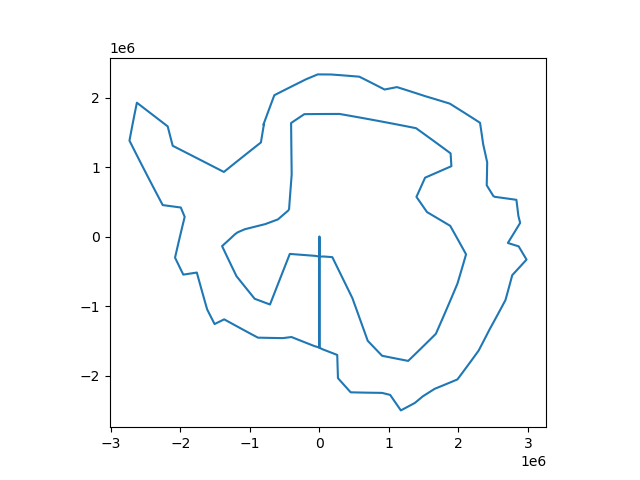

In [10]:
# CS2 graphical mode mask in versions 3.6 and later of the original kml have line to pole
gdfs['gdf_3.6'].boundary.plot()
plt.show()

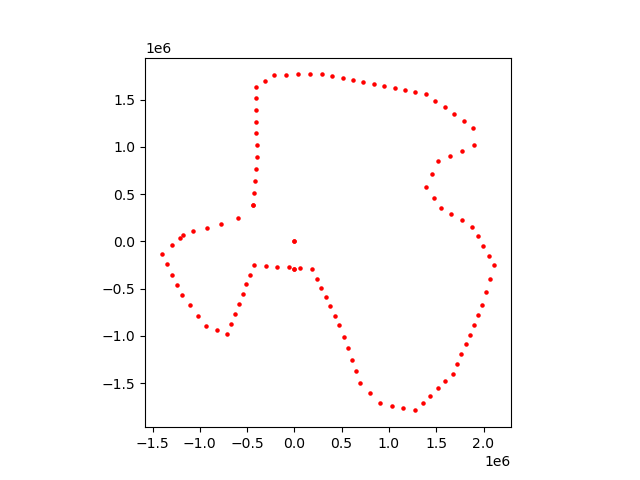

In [11]:
# Investigate aberrant line to near pole
# Extract vertices of polygons
points_list = []

for polygon in gdfs['gdf_3.6'][gdfs['gdf_3.6']['description'] == 'LRM over Antarctica ice sheet'].geometry:
    if polygon.geom_type == 'Polygon':
        exterior_coords = polygon.exterior.coords
        points_list.extend([Point(c) for c in exterior_coords])
    elif polygon.geom_type == 'MultiPolygon':
        for part in polygon:
            exterior_coords = part.exterior.coords
            points_list.extend([Point(c) for c in exterior_coords])

# Create a new GeoDataFrame with these points
points_gdf = gpd.GeoDataFrame(geometry=points_list)

# Plot points
fig, ax = plt.subplots()
points_gdf.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show()

# Delete temp gdf
del points_gdf

In [12]:
# Create functions to remove point closest to the a specified of a polygon
def remove_closest_point_to_centroid(polygon):
    # Calculate the centroid of the polygon
    point_of_interest = Point(0,0)
    # Extract the points (coordinates) of the polygon's exterior
    coords = list(polygon.exterior.coords)
    
    # Find the index of the point closest to the centroid
    closest_point_index = np.argmin([Point(c).distance(point_of_interest) for c in coords[:-1]]) # Exclude the last point because it's the same as the first
    
    # Remove the closest point
    new_coords = [coords[i] for i in range(len(coords)-1) if i != closest_point_index] # Exclude the last repeating point for accurate removal
    
    # Create a new polygon from the remaining points
    new_polygon = Polygon(new_coords)
    
    return new_polygon

In [13]:
# Apply the function to each polygon in the GeoDataFrame
# gdfs['gdf_3.6']['geometry'] = gdfs['gdf_3.6']['geometry'].apply(remove_closest_point_to_centroid)
gdfs['gdf_3.6']['modified_geometry'] = gdfs['gdf_3.6']['geometry'].apply(remove_closest_point_to_centroid)

# If you want to replace the original geometry with the modified one
gdfs['gdf_3.6']['geometry'] = gdfs['gdf_3.6']['modified_geometry']
del gdfs['gdf_3.6']['modified_geometry']

# # Seems you need to run twice to work on all polygons
# Apply the function to each polygon in the GeoDataFrame
gdfs['gdf_3.6']['modified_geometry'] = gdfs['gdf_3.6']['geometry'].apply(remove_closest_point_to_centroid)

# If you want to replace the original geometry with the modified one
gdfs['gdf_3.6']['geometry'] = gdfs['gdf_3.6']['modified_geometry']
del gdfs['gdf_3.6']['modified_geometry']

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


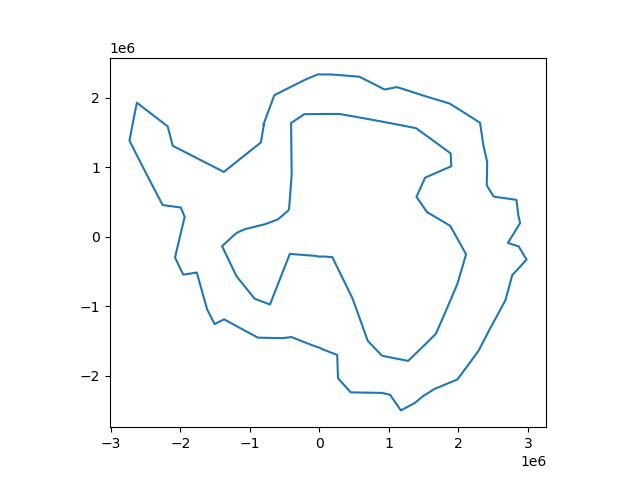

In [14]:
gdfs['gdf_3.6'].boundary.plot()
plt.show()

In [15]:
# Now to find the area difference between the two boundaries for plotting purposes
gdf_SARIn_3_1 = gdfs['gdf_3.1'][gdfs['gdf_3.1']['description'] == 'SARIn in Antarctica']
gdf_LRM_3_1 = gdfs['gdf_3.1'][gdfs['gdf_3.1']['description'] == 'LRM over Antarctica ice sheet']
gdf_SARIn_3_6 = gdfs['gdf_3.6'][gdfs['gdf_3.6']['description'] == 'SARIn in Antarctica']
gdf_LRM_3_6 = gdfs['gdf_3.6'][gdfs['gdf_3.6']['description'] == 'LRM over Antarctica ice sheet']

# Calculate the difference (area between the circles)
difference_area_3_1 = gdf_SARIn_3_1['geometry'].iloc[0].difference(gdf_LRM_3_1['geometry'].iloc[0])
difference_area_3_6 = gdf_SARIn_3_6['geometry'].iloc[0].difference(gdf_LRM_3_6['geometry'].iloc[0])

# Compute the symmetric difference of the two SARIn masks to show area that SARIn mode increased
symmetric_diff = difference_area_3_1.symmetric_difference(difference_area_3_6)

# Delete variables no longer needed
del gdf_LRM_3_1 
del gdf_LRM_3_6

# Create a new GeoDataFrame with the difference area
gdf_SARIn_3_1 = gpd.GeoDataFrame([{'geometry': difference_area_3_1}], crs='EPSG:3031')
gdf_SARIn_3_6 = gpd.GeoDataFrame([{'geometry': difference_area_3_6}], crs='EPSG:3031')

# Create a new GeoDataFrame with the symmetric difference
gdf_SARIn_3_1_3_6_diff = gpd.GeoDataFrame([{'geometry': symmetric_diff}], crs='EPSG:3031')

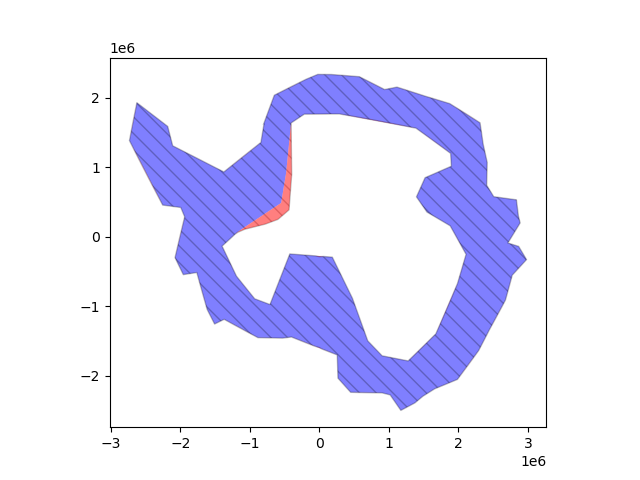

In [16]:
# Plot to ensure worked
fix, ax = plt.subplots()
gdf_SARIn_3_1.plot(ax=ax, alpha=0.5, color='blue')
gdf_SARIn_3_6.plot(ax=ax, alpha=0.25, facecolor='none', edgecolor='k', hatch=r'\\')
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, alpha=0.5, color='red')
plt.show()

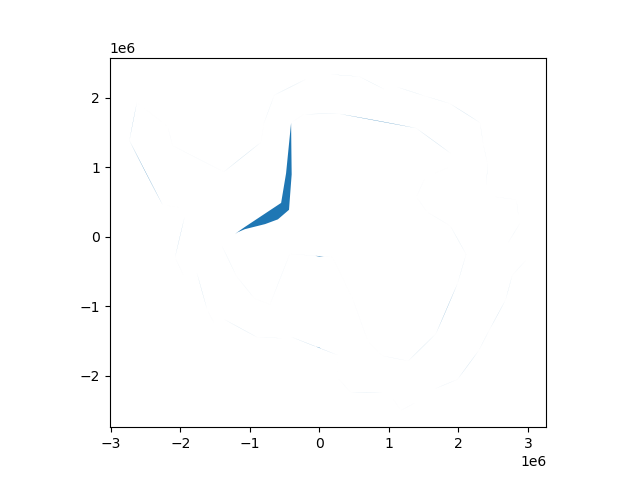

In [17]:
# Difference of two mode masks has many small polygons 
gdf_SARIn_3_1_3_6_diff.plot()
plt.show()

In [18]:
# Let's remove those to get a cleaner looking plot
# Define function to do the job
def keep_largest_polygon(geometry):
    if isinstance(geometry, MultiPolygon):
        # Use the .geoms attribute to explicitly iterate over polygons in a MultiPolygon
        largest_polygon = max(geometry.geoms, key=lambda p: p.area)
        return largest_polygon
    else:
        # If the geometry is not a MultiPolygon, just return it as is
        return geometry

# Apply the function to each geometry in the GeoDataFrame
gdf_SARIn_3_1_3_6_diff['geometry'] = gdf_SARIn_3_1_3_6_diff['geometry'].apply(keep_largest_polygon)

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


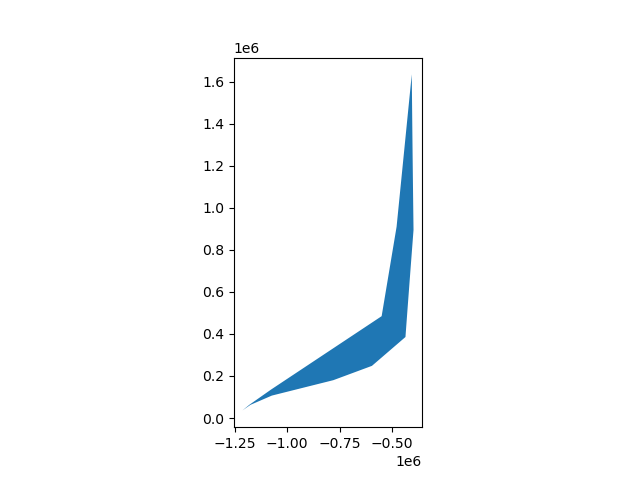

In [19]:
gdf_SARIn_3_1_3_6_diff.plot()
plt.show()

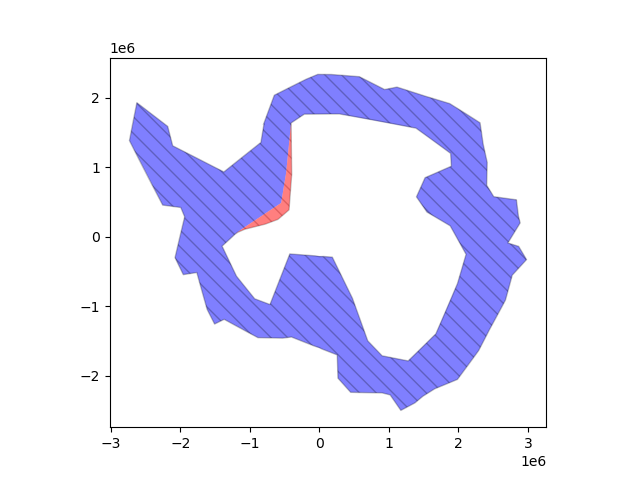

In [20]:
# Plot to ensure worked
fix, ax = plt.subplots()
gdf_SARIn_3_1.plot(ax=ax, alpha=0.5, color='blue')
gdf_SARIn_3_6.plot(ax=ax, alpha=0.25, facecolor='none', edgecolor='k', hatch=r'\\')
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, alpha=0.5, color='red')
plt.show()

In [21]:
# Let's export the geodataframe to use in Fig. 1
gdf_SARIn_3_1.to_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson', driver='GeoJSON')
gdf_SARIn_3_1_3_6_diff.to_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson', driver='GeoJSON')

# CS2 SARIn mode mask

In [ ]:
# Plot CS2 counts with active subglacial lake outlines and SARIn mode mask at two time slices 
# to see if clipping to SARIn mode mask would remove useful data at previously identified lakes

In [ ]:
CS2_Smith2017_subset.time.values[0]

In [ ]:
CS2_Smith2017_subset

In [ ]:
fig, ax = plt.subplots()

x_min=CS2_Smith2017_subset['x'].min()
x_max=CS2_Smith2017_subset['x'].max()
y_min=CS2_Smith2017_subset['y'].min()
y_max=CS2_Smith2017_subset['y'].max()

m = ax.imshow(CS2_Smith2017_subset['count'].sel(time=np.datetime64('2010-07-02T15:00:00.000000000')), 
    extent=[x_min, x_max, y_min, y_max],
    cmap='viridis', vmax=1,
    origin='lower'
             )
static_lakes_gdf.boundary.plot(ax=ax, color='blue', zorder=2)
gdf_SARIn_3_1.boundary.plot(ax=ax, color='red', zorder=2)
gdf_SARIn_symmetric_diff.boundary.plot(ax=ax, color='red', zorder=2)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(m, cax=cax, extend='max')
cbar.set_label('count')

In [ ]:
# There appears to be some useful data and the boundary and within the LRM mode mask, 
# so I will not clip out the LRM mode from the data
# Instead I will plot CS2 counts at each time slice at previously identified lakes
# to detemine when time slices have inadequate data to warrant generating an evolving outline.

# Export pre-processed CS2 data to netcdf

In [ ]:
CS2_Smith2017_subset.to_netcdf(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14.nc')

In [ ]:
# Ensure data import of exported netcdf works properly
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2021.5_relative_to_ATL14.nc')
CS2_Smith2017